In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf, sys
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('tensorflow version: %s' % tf.__version__)
print('python version: %s' % sys.version)
print('python executable location: %s' % sys.executable)

# --------------------------------------------------------------
# --------------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np

from helpers_DL import *

import os, sys, tarfile, time
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator
import pickle
import pandas as pd

params = {'legend.fontsize': 'x-large',
          'font.size'      : 11,
          'figure.figsize' : (17, 6),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17790268017331036557
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11324823962
locality {
  bus_id: 1
}
incarnation: 3826783401141923393
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]
tensorflow version: 1.0.0
python version: 3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
python executable location: /home/aind2/anaconda3/envs/aind-dog/bin/python


In [2]:
df_funding = pd.read_csv('data/funding.csv')
df_startup = pd.read_csv('data/startup.csv')
df_investor = pd.read_csv('data/investor.csv')
df_affiliations = pd.read_csv('data/affiliations.csv')


In [3]:
# df_affiliations of startups
df_startup[:10]

,id,name,description,year,city,state,country,last_funding_amount,last_funding_name,last_funding_on,total_funding_raised,categories,status,COLLECT (DISTINCT o.name)
0,b45eddf3-0b42-404b-b504-1281dec1169a,Limes Audio,Limes Audio develops technology that make two-...,2007.0,Umeå,NaN,SWE,2400000.0,Venture A,2016-03-23,4.643951e+06,audio|communication hardware|telecommunications,acquired,[]
1,63efb3a3-ec4a-4297-a547-4eff70721c61,AvanSci Bio,AvanSci Bio develops analytical laboratory ins...,2011.0,Salt Lake City,UT,USA,160000.0,Debt Financing,2014-05-13,9.600000e+05,analytics|developer platform|electronics,operating,[]
2,c6b20da4-e387-4ae6-9613-f18c6dd1b90b,Caarly,Caarly is a new way of doing business for the ...,2014.0,Singapore,NaN,SGP,NaN,Seed/Angel,2015-05-15,NaN,automotive|consumer goods|mobile apps,acquired,[]
3,cd69fafb-9f9d-41cb-8c7d-05f6e934dc02,Suburban Ostomy Supply Company,Suburban Ostomy Supply distributes disposable ...,1975.0,Holliston,MA,USA,NaN,Private Equity,1995-06-30,NaN,health care|medical,ipo,[]
4,2a0d463c-5792-44be-a56a-52ba2ecbe348,Avantha,Avantha is engaged in the production of writin...,2008.0,New Delhi,NaN,IND,150000000.0,Private Equity,2013-12-16,1.500000e+08,dietary supplements|manufacturing|printing,operating,[]
5,d7f4b7d8-e4eb-465a-b1a4-01767b27a1bf,Qloud,Qloud enables users to enjoy and share their m...,2006.0,Silver Spring,MD,USA,NaN,Seed/Angel,2007-11-06,6.000000e+05,file sharing|music|social network,acquired,[]
6,1d968667-501f-4575-b302-9cc828d4fd71,Shiftgig,Connecting millions of people with millions of...,2012.0,Chicago,IL,USA,20000000.0,Venture C,2017-01-17,5.600000e+07,apps|hospitality|recruiting,operating,[]
7,5208e083-3263-4e5c-a322-932f5e6f399b,CipherMax,CipherMax provides storage security solutions ...,2000.0,San Jose,CA,USA,9535713.0,Venture B,2007-02-25,1.415357e+08,compliance|government|security,closed,[]
8,5789689c-86ae-4b91-9b6d-aaa9b8727dea,ZendyHealth,Priceline marketplace for healthcare,2014.0,Los Angeles,CA,USA,500000.0,Convertible Note,2016-07-13,1.850000e+06,beauty|cosmetics|cosmetic surgery|dental|healt...,operating,[]
9,2d5cbd88-3b74-462e-99da-797eb1bf2381,SecurFone America,SecurFone America,1996.0,San Diego,CA,USA,1300000.0,Venture A,2000-02-04,1.300000e+06,e-commerce|internet|travel,operating,[]


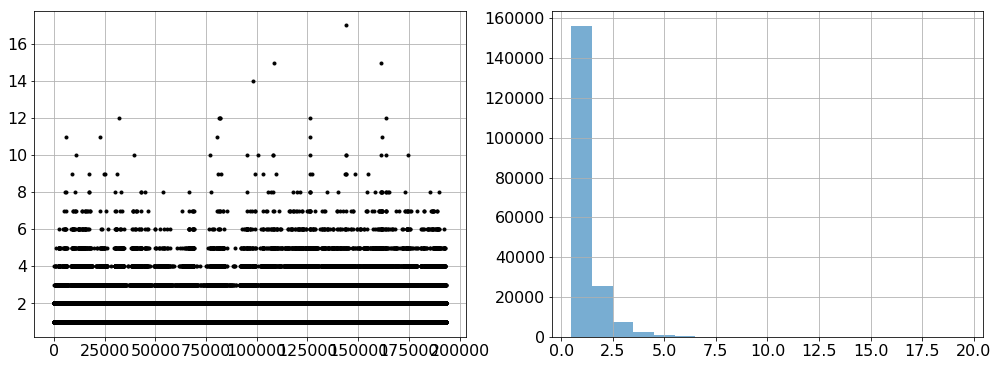

In [4]:
a = df_funding['num_investments'].as_matrix()
plt.figure()
ax = plt.subplot(121)
ax.plot(a, 'k.')

# .............................................

ax = plt.subplot(122)
ax.hist(a, bins=np.linspace(.5,19.5,20), alpha=.6);

In [5]:
gr_inv = df_funding.groupby(by='investor_id').groups
gr_sta = df_funding.groupby(by='startup_id').groups

invID_to_i = {}
staID_to_j = {}
i_to_invID = {}
j_to_staID = {}

#.............................
i = -1
for k,v in gr_inv.items():
    i = i + 1
    invID_to_i[k] = i
    i_to_invID[i] = k
    
j = -1
for k,v in gr_sta.items():
    j = j + 1
    staID_to_j[k] = j
    j_to_staID[j] = k
#.............................
n_investments, n_investors, n_startups = (len(df_funding), len(invID_to_i), len(staID_to_j))

print('n_investments: \t%i' % (n_investments,)) 
print('n_investors: \t%i' % (n_investors,)) 
print('n_startups: \t%i' % (n_startups,))


n_investments: 	193341
n_investors: 	41838
n_startups: 	64764


### Obtain `R` and `R_indices`:
### Randomly sample indices of N/A entries in matrix `R`, then load the data into `R0_indices` and `R0=0`.
### Then, find `R0_indices` where there's collisions with `R_indices`.

In [62]:
### Obtain `R` and `R_indices`:

df_funding['i'] =  df_funding['investor_id'].apply(lambda row: invID_to_i[row])
df_funding['j'] =  df_funding['startup_id'].apply(lambda row: staID_to_j[row])
R_indices = df_funding[['i', 'j']].as_matrix()
R = np.ones(len(R_indices))
# .....................................................

### Randomly sample indices of N/A entries in matrix `R`, then load the data into `R0_indices` and `R0=0`.


# zero_examples = len(R)*10
# R0 = np.zeros((zero_examples))
# R0_indices = np.zeros((zero_examples, 2), dtype=np.int64)
# R0_indices[:,0] = np.random.choice(n_investors, zero_examples) 
# R0_indices[:,1] = np.random.choice(n_startups, zero_examples) 

### Then, find `R0_indices` where there's collisions with `R_indices`.
# # This section takes 60 min to run!!!
# start = time.time()
# collision_i = []

# for i, row in enumerate(R0_indices):
#     a = np.equal(row, R_indices)
#     if np.round(np.mean(a, axis=1)).astype('bool').any():
#         # checks if there's any row of R0_indices which is equal to some row of R_indices.
#         o = print_runtime(start,p_flag=False)
#         print('' + o)
#         print('collision detected at i: %i, row: %a' % (i, row))
#         collision_i.append(i)

# # .....................................................
# with open('data/collision_i.pkl', 'wb') as f:
#     pickle.dump(collision_i, f, pickle.HIGHEST_PROTOCOL)
# with open('data/R0_indices.pkl', 'wb') as f:
#     pickle.dump(R0_indices, f, pickle.HIGHEST_PROTOCOL)

# print_runtime(start)
# # .....................................................
# # .....................................................
# # .....................................................

with open('data/collision_i.pkl', 'rb') as f:
    collision_i = pickle.load(f)
    
with open('data/R0_indices.pkl', 'rb') as f:
    R0_indices = pickle.load(f)

""" Set the following exceptions in R0 to 1:
     R0[collision_i[...]] = 1"""

# correct the R0 vector where there are collisions with R.
# R, R_indices = shuffler(R, R_indices)
R0 = np.zeros(len(R0_indices))
for i in collision_i:
    R0[i] = 1


# R = R[:int(len(R)*.25)]
# R_indices = R_indices[:len(R)]
R0 = R0[:len(R)]
R0_indices = R0_indices[:len(R)]
print('R.shape: %a \nR_indices.shape: %a' % (R.shape, R_indices.shape))



R.shape: (193341,) 
R_indices.shape: (193341, 2)


### Shuffle and Split Data:

In [63]:
data_R_indices, data_R = shuffler(np.concatenate((R_indices, R0_indices)), np.concatenate((R, R0)))
train_R_indices, train_R, cv_R_indices, cv_R, test_R_indices, test_R = split_data(data_R_indices, data_R)
print('train_R_indices.shape: \t%a' % (train_R_indices.shape,))
print('cv_R_indices.shape: \t%a' % (cv_R_indices.shape,))
print('test_R_indices.shape: \t%a' % (test_R_indices.shape,))

train_R_indices.shape: 	(247476, 2)
cv_R_indices.shape: 	(61869, 2)
test_R_indices.shape: 	(77337, 2)


In [64]:
## Figure out Feature Vectors for Investors:

'''
FEATURE VECTOR, X:
    investor IDs One-Hot Vector : [...]
    start_up IDs One_Hot Vector: [...]
    mutual affiliations: log(n_affiliations btw Investor and Start-up: [...]

TARGET, y:
    [binary target vector: [....]: {0,1}
'''

n_input = n_investors + n_startups + 1
n_input


106603

# Deep Learning Model
### Training:

NUM_EPOCHS: 2               
LAMBDA: 0.0
lr: 0.01
n_batches: 966
BATCH_SIZE: 256
threshold: 0.5
Epoch 1 ______________________________________________________________
batch_no:967/966, loss_train:0.5377, t=220.3 sec


/home/aind2/miscelleneous_projects/VentureHub/helpers_DL.py:61: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp/float(tp+fp)


loss_train: 0.5377, **loss_cv: 0.4995**, f1_score_cv: 0.7554 @threshold:0.36   !! CHECKPOINT!!
Epoch 2 ______________________________________________________________
batch_no:967/966, loss_train:0.2555, t=243.1 sec
loss_train: 0.2555, **loss_cv: 0.5787**, f1_score_cv: 0.7356 @threshold:0.48    

Runtime: 9 min 27 sec


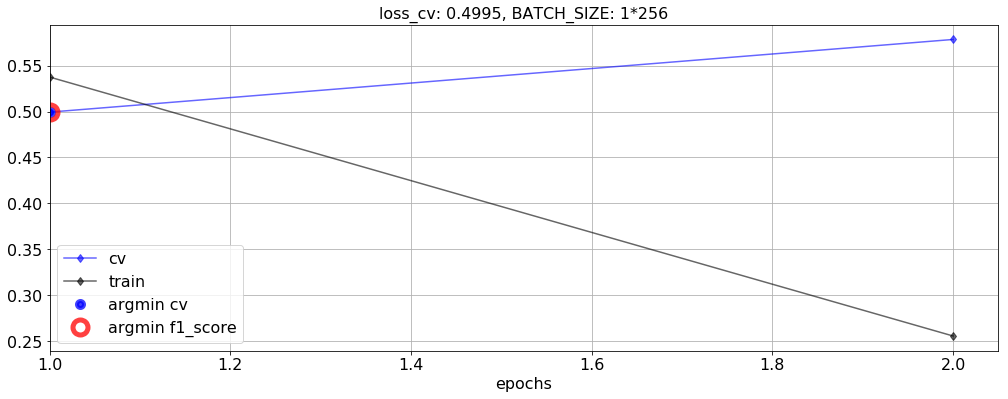

In [123]:
### Training:

LAMBDA = 0.000
BATCH_SIZE = 256
lr = 0.01
k = 2 
NUM_EPOCHS = 2

#.............................................. 
start = time.time()
print('Start: construct_graph()... ', end='\r')
train_op, loss_op, X, y, y_pred_op = construct_graph(
                                            LAMBDA, lr, BATCH_SIZE, n_input=n_investors+n_startups+1)
print('                            ', end='\r')
#.............................................. 

start = time.time() 
loss_cv_arr, loss_train_arr, batch = train_the_model(
                                            train_R_indices, train_R, cv_R_indices, cv_R, test_R_indices, test_R,
                                            BATCH_SIZE, NUM_EPOCHS, LAMBDA, lr, 
                                            train_op, loss_op, y_pred_op, X, y,  
                                            n_investors, n_input, threshold=0.5)
#.............................................. 
# plotting....

plotter(loss_cv_arr, loss_train_arr, batch)

#.............................................. 
print_runtime(start)
# os.system('afplay System/Library/Sounds/Ping.aiff')

Runtime: 1 min 56 sec


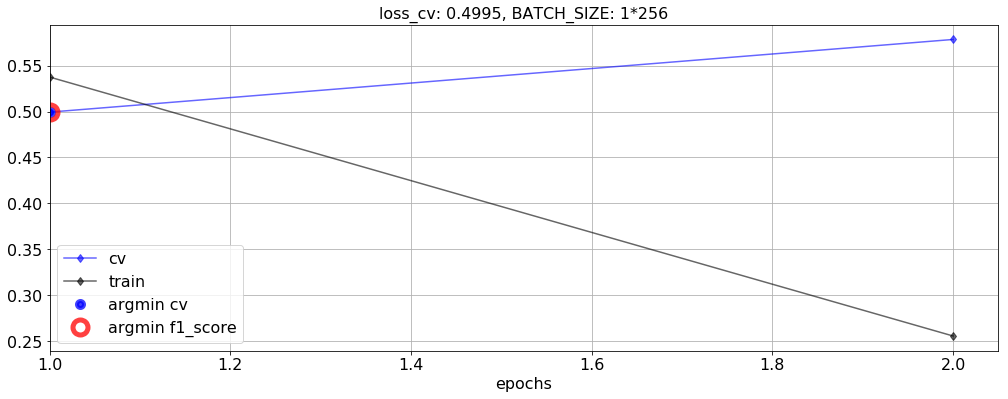

In [124]:
### Restore session variables from disk:

# Restore the weights of the best model to be able to calculate 
# the loss function, precision and recall on CV and test sets.
start = time.time()
# .................................................
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, 'saved_models/DL_models/best_model.ckpt') 
preds_cv, _loss_cv = evaluate_preds_and_loss(
                                    sess, cv_R, cv_R_indices, loss_op, y_pred_op, X, y, 
                                    BATCH_SIZE, n_investors, n_input)
preds_test, _loss_test = evaluate_preds_and_loss(
                                    sess, test_R, test_R_indices, loss_op, y_pred_op, X, y, 
                                    BATCH_SIZE, n_investors, n_input)
sess.close()
# .................................................
# Load the results of the last epoch to plot the loss functions and 
with open('saved_models/loss_train_and_cv.pkl','rb') as f:
    loss_train_arr, loss_cv_arr, batch = pickle.load(f)

plotter(loss_cv_arr, loss_train_arr, batch)

# .................................................
print_runtime(start) 

precision_cv: 0.532
recall_cv: 0.953 <==
f1_score_cv: 0.683


/home/aind2/miscelleneous_projects/VentureHub/helpers_DL.py:61: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp/float(tp+fp)


<IPython.core.display.Latex object>

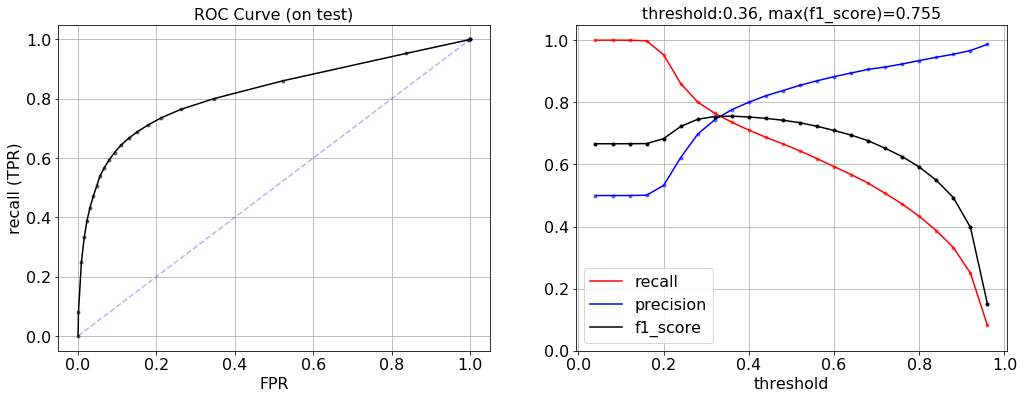

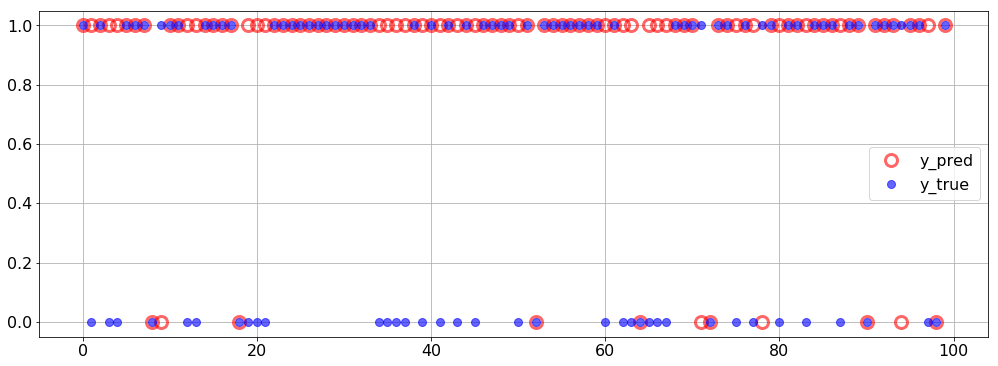

In [125]:
### Calculate and plot, precision, recall, f1_score and ROC curve.

_, accuracy, precision, recall, f1_score, fpr = ROC_statistics(preds_cv, cv_R )

idx = np.nanargmax(f1_score)

# ................................................................

ax = plt.subplot(121)
ax.plot(fpr, recall, 'k')
ax.plot(fpr, recall, 'k.', alpha=.5)
ax.plot([0,1], [0,1],'b--', alpha=.3)
ax.set_xlabel('FPR')
ax.set_ylabel('recall (TPR)')
ax.set_title('ROC Curve (on test)')

ax = plt.subplot(122)
threshold = np.linspace(0,1,len(precision))
ax.plot(threshold[1:-1], recall[1:-1], 'r')
ax.plot(threshold[1:-1], precision[1:-1], 'b')
ax.plot(threshold[1:-1], f1_score[1:-1], 'k')
ax.set_ylim((0,1.05))
ax.set_xlabel('threshold')
ax.set_title('threshold:{:3.2f}, max(f1_score)={:5.3f}'.format(threshold[idx], f1_score[idx]))
ax.legend(['recall', 'precision','f1_score']);
ax.plot(threshold[1:-1], recall[1:-1], 'r.', alpha=.5)
ax.plot(threshold[1:-1], precision[1:-1], 'b.', alpha=.5)
ax.plot(threshold[1:-1], f1_score[1:-1], 'k.')
#.........................................

# th = threshold[idx]
th = .2
y_pred_cv_01, _, precision_cv, recall_cv, f1_score_cv, _ = ROC_statistics(
                                                preds_cv, cv_R, threshold=th) 

print('precision_cv:{:6.3f}\nrecall_cv:{:6.3f} <==\nf1_score_cv:{:6.3f}'.format(
                    precision_cv, recall_cv, f1_score_cv))

# ............................................................................
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(y_pred_cv_01[:100],'ro', alpha=.6, markersize=12, markerfacecolor='None', markeredgewidth=3)
ax.plot(cv_R[:100],'b.', alpha=.6, markersize=16)
ax.legend(('y_pred', 'y_true'), loc='right') 
# ............................................................................

from IPython.display import Markdown, Latex
Latex('$$$$ $$threshold='+ '{:1.2f}'.format(th) +'$$ $$$$ \
        $$precision = \\frac{tp}{tp+fp}=' + '{:1.3f}'.format((precision_cv)) + '$$ $$$$ \
        $$recall = \\frac{tp}{tp+fn}=' + '{:1.3f}'.format((recall_cv)) + '$$ $$$$ \
        $$F_1\\_score=2 \, \\frac{precision \\cdot recall}{precision + recall}='\
      + '{:1.3f}'.format((f1_score_cv)) + '$$')


### TO DO:
> Training on full data set `R` results in a max `f1_score` of `.74`.  
However, when trained on `R[0:int(len(R)*0.25)]`, `f1_score` reaches `0.88`!!!   
How come?!?!  
Is there something wrong with some portion of the data??
 
Opinion: The way I construct `R0` and `R0_indices` is a total hack. Even though, I use the damping coefficient `cui=01` while adding it to the loss fucntion, it might still be messing up the training data.

> - `lr=0.01`: `f1_score=0.757`. Precision and recall plots are flat 
- `lr=0.001`: `f1_score=0.738`. Recall drops sharply as threshold is increased form 0.0